In [1]:
#CODE TO CLEAR WORKING DIRECTORY

"""
import os
import shutil

working_dir = '/kaggle/working/'

#clear all files and subdirectories in the /kaggle/working directory
for filename in os.listdir(working_dir):
    file_path = os.path.join(working_dir, filename)
    try:
        if os.path.isdir(file_path):
            shutil.rmtree(file_path)  #remove directories
        else:
            os.remove(file_path)  #remove files
    except Exception as e:
        print(f"Error while deleting {file_path}: {e}")
"""

'\nimport os\nimport shutil\n\nworking_dir = \'/kaggle/working/\'\n\n#clear all files and subdirectories in the /kaggle/working directory\nfor filename in os.listdir(working_dir):\n    file_path = os.path.join(working_dir, filename)\n    try:\n        if os.path.isdir(file_path):\n            shutil.rmtree(file_path)  #remove directories\n        else:\n            os.remove(file_path)  #remove files\n    except Exception as e:\n        print(f"Error while deleting {file_path}: {e}")\n'

In [2]:
!pip install transformers datasets torch accelerate peft -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.6 MB/s eta 0:00:00
ERROR: pip's dependency 

In [3]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, ClassLabel, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, confusion_matrix
import time

#set random seeds
SEED = 4213
torch.manual_seed(SEED)
np.random.seed(SEED)

#check gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

2025-10-17 11:46:32.148675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760701592.333262      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760701592.385659      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


using device: cuda


In [4]:
#load medical abstracts dataset
dataset = load_dataset("TimSchopf/medical_abstracts")

#check original dataset structure
print("original dataset keys:", dataset.keys())
print("train split size:", len(dataset['train']))
print("test split size:", len(dataset['test']))

#check the actual label range
print("\nchecking label range:")
train_labels = [item['condition_label'] for item in dataset['train']]
print(f"min label: {min(train_labels)}")
print(f"max label: {max(train_labels)}")
print(f"unique labels: {sorted(set(train_labels))}")

#labels are 1-5, need to convert to 0-4
def relabel(example):
    example['condition_label'] = example['condition_label'] - 1
    return example

dataset['train'] = dataset['train'].map(relabel)
dataset['test'] = dataset['test'].map(relabel)

print("\nafter relabeling (converting 1-5 to 0-4):")
train_labels = [item['condition_label'] for item in dataset['train']]
print(f"min label: {min(train_labels)}")
print(f"max label: {max(train_labels)}")

#convert condition_label to ClassLabel type for stratification
label_names_list = ["neoplasms", "digestive system diseases", "nervous system diseases", 
                    "cardiovascular diseases", "general pathological conditions"]
class_label = ClassLabel(names=label_names_list)

#cast the column to ClassLabel type
dataset['train'] = dataset['train'].cast_column('condition_label', class_label)
dataset['test'] = dataset['test'].cast_column('condition_label', class_label)

#create validation set from training set (15% split)
train_val_split = dataset['train'].train_test_split(test_size=0.15, seed=SEED, stratify_by_column='condition_label')

#reorganize dataset with train/validation/test splits
dataset = {
    'train': train_val_split['train'],
    'validation': train_val_split['test'],
    'test': dataset['test']
}

print("\nnew dataset structure after creating validation set:")
print(f"train split size: {len(dataset['train'])}")
print(f"validation split size: {len(dataset['validation'])}")
print(f"test split size: {len(dataset['test'])}")

#examine first example
print("\nfirst example:")
print(dataset['train'][0])

#check class distribution in all splits
for split_name in ['train', 'validation', 'test']:
    print(f"\nclass distribution in {split_name} set:")
    labels = [item['condition_label'] for item in dataset[split_name]]
    unique, counts = np.unique(labels, return_counts=True)
    for label, count in zip(unique, counts):
        print(f"  class {label}: {count} samples ({count/len(labels)*100:.1f}%)")

#label names mapping
label_names = {
    0: "neoplasms",
    1: "digestive system diseases",
    2: "nervous system diseases", 
    3: "cardiovascular diseases",
    4: "general pathological conditions"
}
print("\nlabel mapping:")
for k, v in label_names.items():
    print(f"{k}: {v}")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/7.67M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11550 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2888 [00:00<?, ? examples/s]

original dataset keys: dict_keys(['train', 'test'])
train split size: 11550
test split size: 2888

checking label range:
min label: 1
max label: 5
unique labels: [1, 2, 3, 4, 5]


Map:   0%|          | 0/11550 [00:00<?, ? examples/s]

Map:   0%|          | 0/2888 [00:00<?, ? examples/s]


after relabeling (converting 1-5 to 0-4):
min label: 0
max label: 4


Casting the dataset:   0%|          | 0/11550 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2888 [00:00<?, ? examples/s]


new dataset structure after creating validation set:
train split size: 9817
validation split size: 1733
test split size: 2888

first example:
{'condition_label': 0, 'medical_abstract': 'Prevention and changing demographics. The underserved and cancer. This paper illustrates the complexity of the "cancer control in the underserved" problem, especially as it is affected currently, and will be in the future, by the multiple demographic changes in the United States. It does so by extensively quoting from four rather different articles by authors from a variety of backgrounds in health, management, and economics. Another issue is that although the articles quoted refer mainly to secondary and tertiary prevention, they do apply equally to primary prevention and health promotion. Furthermore, the twin issues of priority and ethnic/cultural differences need to be addressed insofar as they affect health risks, risk reduction efforts, early diagnosis, treatment, and rehabilitation/disability re

In [5]:
#tokenization function
def tokenize_dataset(dataset, tokenizer, max_length=512):
    """
    tokenize the medical abstracts dataset
    """
    def tokenize_function(examples):
        return tokenizer(
            examples['medical_abstract'],
            padding='max_length',
            truncation=True,
            max_length=max_length
        )
    
    #handle both DatasetDict and regular dict
    if isinstance(dataset, dict) and not isinstance(dataset, DatasetDict):
        #convert dict to DatasetDict
        dataset = DatasetDict(dataset)
    
    tokenized = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=['medical_abstract']
    )
    
    #rename label column to labels
    tokenized = tokenized.rename_column('condition_label', 'labels')
    
    #set format for pytorch
    tokenized.set_format('torch')
    
    return tokenized

print("tokenization function defined")


#compute metrics function
def compute_metrics(eval_pred):
    """
    compute accuracy, f1, precision, recall for evaluation
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_weighted = f1_score(labels, predictions, average='weighted')
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='macro'
    )
    
    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision': precision,
        'recall': recall
    }
    
print("tokenization function defined")
print("metrics function defined")

tokenization function defined
tokenization function defined
metrics function defined


# DistilBERT

In [6]:
#load distilbert tokenizer and model
model_name = "distilbert-base-uncased"
tokenizer_distilbert = AutoTokenizer.from_pretrained(model_name)
model_distilbert_full = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5
)

print(f"loaded {model_name}")
print(f"total parameters: {model_distilbert_full.num_parameters():,}")

#tokenize dataset
tokenized_dataset = tokenize_dataset(dataset, tokenizer_distilbert)

#training arguments
training_args_full = TrainingArguments(
    output_dir="./distilbert_full",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    push_to_hub=False,
    report_to="none"
)

#create trainer
trainer_distilbert_full = Trainer(
    model=model_distilbert_full,
    args=training_args_full,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer_distilbert,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer_distilbert)
)

print("\nstarting full fine-tuning")
start_time = time.time()
train_result = trainer_distilbert_full.train()
training_time_full = time.time() - start_time

print(f"\ntraining completed in {training_time_full:.2f} seconds")
print(f"training time: {training_time_full/60:.2f} minutes")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


loaded distilbert-base-uncased
total parameters: 66,957,317


Map:   0%|          | 0/9817 [00:00<?, ? examples/s]

Map:   0%|          | 0/1733 [00:00<?, ? examples/s]

Map:   0%|          | 0/2888 [00:00<?, ? examples/s]

/tmp/ipykernel_36/1804848369.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_distilbert_full = Trainer(



starting full fine-tuning


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision,Recall
1,0.904100,0.920328,0.616849,0.602929,0.595459,0.598728,0.630276
2,0.787000,0.881680,0.628967,0.611086,0.622161,0.612156,0.616494
3,0.688900,0.900237,0.615695,0.606818,0.606955,0.595070,0.627530



training completed in 1003.10 seconds
training time: 16.72 minutes


In [7]:
#load fresh distilbert model
model_distilbert_lora_base = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5
)

#configure lora
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,  #rank
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["q_lin", "v_lin"]  #attention layers in distilbert
)

#apply lora to model
model_distilbert_lora = get_peft_model(model_distilbert_lora_base, lora_config)

#print trainable parameters
model_distilbert_lora.print_trainable_parameters()

#training arguments (same as full fine-tuning)
training_args_lora = TrainingArguments(
    output_dir="./distilbert_lora",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    push_to_hub=False,
    report_to="none"
)

#create trainer
trainer_distilbert_lora = Trainer(
    model=model_distilbert_lora,
    args=training_args_lora,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer_distilbert,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer_distilbert)
)

print("\nstarting lora fine-tuning...")
start_time = time.time()
train_result_lora = trainer_distilbert_lora.train()
training_time_lora = time.time() - start_time

print(f"\ntraining completed in {training_time_lora:.2f} seconds")
print(f"training time: {training_time_lora/60:.2f} minutes")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/1040984465.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_distilbert_lora = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 741,893 || all params: 67,699,210 || trainable%: 1.0959

starting lora fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision,Recall
1,1.068000,1.045549,0.577611,0.528380,0.558270,0.568899,0.530929
2,0.990800,0.989092,0.596076,0.574259,0.588875,0.587089,0.570662
3,0.991200,0.980539,0.598384,0.578067,0.590543,0.587617,0.576853



training completed in 794.65 seconds
training time: 13.24 minutes


In [8]:
#evaluate distilbert full fine-tuning

#evaluate on test set
test_results_full = trainer_distilbert_full.evaluate(tokenized_dataset['test'])

print("distilbert full fine-tuning - test results:")
print(f"accuracy: {test_results_full['eval_accuracy']:.4f}")
print(f"f1 macro: {test_results_full['eval_f1_macro']:.4f}")
print(f"f1 weighted: {test_results_full['eval_f1_weighted']:.4f}")
print(f"precision: {test_results_full['eval_precision']:.4f}")
print(f"recall: {test_results_full['eval_recall']:.4f}")

#get predictions for confusion matrix
predictions_full = trainer_distilbert_full.predict(tokenized_dataset['test'])
y_pred_full = np.argmax(predictions_full.predictions, axis=1)
y_true = predictions_full.label_ids

#store results for comparison
results_distilbert_full = {
    'model': 'distilbert-full',
    'training_time': training_time_full,
    'accuracy': test_results_full['eval_accuracy'],
    'f1_macro': test_results_full['eval_f1_macro'],
    'f1_weighted': test_results_full['eval_f1_weighted'],
    'precision': test_results_full['eval_precision'],
    'recall': test_results_full['eval_recall'],
    'num_parameters': model_distilbert_full.num_parameters(),
    'trainable_parameters': model_distilbert_full.num_parameters(),  
    'trainable_percent': 100.0  
}

print(f"\ntotal parameters: {results_distilbert_full['num_parameters']:,}")

distilbert full fine-tuning - test results:
accuracy: 0.6361
f1 macro: 0.6336
f1 weighted: 0.6280
precision: 0.6317
recall: 0.6446

total parameters: 66,957,317


In [9]:
#evaluate distilbert lora

#evaluate on test set
test_results_lora = trainer_distilbert_lora.evaluate(tokenized_dataset['test'])

print("distilbert lora - test results:")
print(f"accuracy: {test_results_lora['eval_accuracy']:.4f}")
print(f"f1 macro: {test_results_lora['eval_f1_macro']:.4f}")
print(f"f1 weighted: {test_results_lora['eval_f1_weighted']:.4f}")
print(f"precision: {test_results_lora['eval_precision']:.4f}")
print(f"recall: {test_results_lora['eval_recall']:.4f}")

#get predictions
predictions_lora = trainer_distilbert_lora.predict(tokenized_dataset['test'])
y_pred_lora = np.argmax(predictions_lora.predictions, axis=1)

#get trainable parameters count
trainable_params = sum(p.numel() for p in model_distilbert_lora.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model_distilbert_lora.parameters())

#store results
results_distilbert_lora = {
    'model': 'distilbert-lora',
    'training_time': training_time_lora,
    'accuracy': test_results_lora['eval_accuracy'],
    'f1_macro': test_results_lora['eval_f1_macro'],
    'f1_weighted': test_results_lora['eval_f1_weighted'],
    'precision': test_results_lora['eval_precision'],
    'recall': test_results_lora['eval_recall'],
    'num_parameters': total_params,
    'trainable_parameters': trainable_params,
    'trainable_percent': 100 * trainable_params / total_params
}

print(f"\ntotal parameters: {total_params:,}")
print(f"trainable parameters: {trainable_params:,}")
print(f"trainable %: {results_distilbert_lora['trainable_percent']:.2f}%")

distilbert lora - test results:
accuracy: 0.5987
f1 macro: 0.5920
f1 weighted: 0.5929
precision: 0.6028
recall: 0.5892

total parameters: 67,699,210
trainable parameters: 741,893
trainable %: 1.10%


# PubMedBERT

In [10]:
#pubmedbert full fine-tuning

#pubmedbert: domain-specific model pretrained on biomedical literature
pubmed_model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"

#load tokenizer and model
tokenizer_pubmed = AutoTokenizer.from_pretrained(pubmed_model_name)
model_pubmed_full = AutoModelForSequenceClassification.from_pretrained(
    pubmed_model_name,
    num_labels=5
)

print(f"loaded {pubmed_model_name}")
print(f"total parameters: {model_pubmed_full.num_parameters():,}")

#tokenize dataset with pubmedbert tokenizer
tokenized_dataset_pubmed = tokenize_dataset(dataset, tokenizer_pubmed)

#training arguments
training_args_pubmed = TrainingArguments(
    output_dir="./pubmedbert_full",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    push_to_hub=False,
    report_to="none"
)

#create trainer
trainer_pubmed_full = Trainer(
    model=model_pubmed_full,
    args=training_args_pubmed,
    train_dataset=tokenized_dataset_pubmed['train'],
    eval_dataset=tokenized_dataset_pubmed['validation'],
    tokenizer=tokenizer_pubmed,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer_pubmed)
)

print("\nstarting pubmedbert full fine-tuning...")
start_time = time.time()
train_result_pubmed = trainer_pubmed_full.train()
training_time_pubmed = time.time() - start_time

print(f"\ntraining completed in {training_time_pubmed:.2f} seconds")
print(f"training time: {training_time_pubmed/60:.2f} minutes")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


loaded microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
total parameters: 109,486,085


Map:   0%|          | 0/9817 [00:00<?, ? examples/s]

Map:   0%|          | 0/1733 [00:00<?, ? examples/s]

Map:   0%|          | 0/2888 [00:00<?, ? examples/s]

/tmp/ipykernel_36/540922909.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_pubmed_full = Trainer(



starting pubmedbert full fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision,Recall
1,0.809200,0.833281,0.646855,0.638011,0.626326,0.633851,0.677203
2,0.681300,0.822872,0.637623,0.627994,0.633937,0.619853,0.641313
3,0.578500,0.867141,0.633006,0.622900,0.624842,0.611195,0.645377



training completed in 1980.33 seconds
training time: 33.01 minutes


In [11]:
#evaluate pubmedbert

#evaluate on test set
test_results_pubmed = trainer_pubmed_full.evaluate(tokenized_dataset_pubmed['test'])

print("pubmedbert full fine-tuning - test results:")
print(f"accuracy: {test_results_pubmed['eval_accuracy']:.4f}")
print(f"f1 macro: {test_results_pubmed['eval_f1_macro']:.4f}")
print(f"f1 weighted: {test_results_pubmed['eval_f1_weighted']:.4f}")
print(f"precision: {test_results_pubmed['eval_precision']:.4f}")
print(f"recall: {test_results_pubmed['eval_recall']:.4f}")

#get predictions
predictions_pubmed = trainer_pubmed_full.predict(tokenized_dataset_pubmed['test'])
y_pred_pubmed = np.argmax(predictions_pubmed.predictions, axis=1)

#store results
results_pubmed_full = {
    'model': 'pubmedbert-full',
    'training_time': training_time_pubmed,
    'accuracy': test_results_pubmed['eval_accuracy'],
    'f1_macro': test_results_pubmed['eval_f1_macro'],
    'f1_weighted': test_results_pubmed['eval_f1_weighted'],
    'precision': test_results_pubmed['eval_precision'],
    'recall': test_results_pubmed['eval_recall'],
    'num_parameters': model_pubmed_full.num_parameters(),
    'trainable_parameters': model_pubmed_full.num_parameters(),
    'trainable_percent': 100.0
}

print(f"\ntotal parameters: {results_pubmed_full['num_parameters']:,}")

pubmedbert full fine-tuning - test results:
accuracy: 0.6548
f1 macro: 0.6519
f1 weighted: 0.6297
precision: 0.6474
recall: 0.6995

total parameters: 109,486,085


In [12]:
#pubmedbert lora fine-tuning

#load fresh pubmedbert model
model_pubmed_lora_base = AutoModelForSequenceClassification.from_pretrained(
    pubmed_model_name,
    num_labels=5
)

#configure lora (same settings as distilbert lora)
lora_config_pubmed = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,  #rank
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules="all-linear"
)

#apply lora to model
model_pubmed_lora = get_peft_model(model_pubmed_lora_base, lora_config_pubmed)

#print trainable parameters
model_pubmed_lora.print_trainable_parameters()

#training arguments (same as other experiments)
training_args_pubmed_lora = TrainingArguments(
    output_dir="./pubmedbert_lora",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    push_to_hub=False,
    report_to="none"
)

#create trainer
trainer_pubmed_lora = Trainer(
    model=model_pubmed_lora,
    args=training_args_pubmed_lora,
    train_dataset=tokenized_dataset_pubmed['train'],
    eval_dataset=tokenized_dataset_pubmed['validation'],
    tokenizer=tokenizer_pubmed,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer_pubmed)
)

print("\nstarting pubmedbert lora fine-tuning...")
start_time = time.time()
train_result_pubmed_lora = trainer_pubmed_lora.train()
training_time_pubmed_lora = time.time() - start_time

print(f"\ntraining completed in {training_time_pubmed_lora:.2f} seconds")
print(f"training time: {training_time_pubmed_lora/60:.2f} minutes")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/2576995398.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_pubmed_lora = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 1,343,237 || all params: 110,829,322 || trainable%: 1.2120

starting pubmedbert lora fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision,Recall
1,1.020300,0.962184,0.603001,0.556995,0.580878,0.595110,0.563348
2,0.861800,0.859064,0.639931,0.631238,0.629562,0.620168,0.653218
3,0.828800,0.847203,0.643970,0.634627,0.631899,0.623435,0.659376



training completed in 1784.35 seconds
training time: 29.74 minutes


In [13]:
#evaluate pubmedbert lora

#evaluate on test set
test_results_pubmed_lora = trainer_pubmed_lora.evaluate(tokenized_dataset_pubmed['test'])

print("pubmedbert lora - test results:")
print(f"accuracy: {test_results_pubmed_lora['eval_accuracy']:.4f}")
print(f"f1 macro: {test_results_pubmed_lora['eval_f1_macro']:.4f}")
print(f"f1 weighted: {test_results_pubmed_lora['eval_f1_weighted']:.4f}")
print(f"precision: {test_results_pubmed_lora['eval_precision']:.4f}")
print(f"recall: {test_results_pubmed_lora['eval_recall']:.4f}")

#get predictions
predictions_pubmed_lora = trainer_pubmed_lora.predict(tokenized_dataset_pubmed['test'])
y_pred_pubmed_lora = np.argmax(predictions_pubmed_lora.predictions, axis=1)

#get trainable parameters count
trainable_params_pubmed = sum(p.numel() for p in model_pubmed_lora.parameters() if p.requires_grad)
total_params_pubmed = sum(p.numel() for p in model_pubmed_lora.parameters())

#store results
results_pubmed_lora = {
    'model': 'pubmedbert-lora',
    'training_time': training_time_pubmed_lora,
    'accuracy': test_results_pubmed_lora['eval_accuracy'],
    'f1_macro': test_results_pubmed_lora['eval_f1_macro'],
    'f1_weighted': test_results_pubmed_lora['eval_f1_weighted'],
    'precision': test_results_pubmed_lora['eval_precision'],
    'recall': test_results_pubmed_lora['eval_recall'],
    'num_parameters': total_params_pubmed,
    'trainable_parameters': trainable_params_pubmed,
    'trainable_percent': 100 * trainable_params_pubmed / total_params_pubmed
}

print(f"\ntotal parameters: {total_params_pubmed:,}")
print(f"trainable parameters: {trainable_params_pubmed:,}")
print(f"trainable %: {results_pubmed_lora['trainable_percent']:.2f}%")

pubmedbert lora - test results:
accuracy: 0.6517
f1 macro: 0.6513
f1 weighted: 0.6342
precision: 0.6378
recall: 0.6868

total parameters: 110,829,322
trainable parameters: 1,343,237
trainable %: 1.21%


# Comparison

COMPARISON OF ALL MODELS


,model,training_time,accuracy,f1_macro,f1_weighted,precision,recall,num_parameters,trainable_parameters,trainable_percent
0,distilbert-full,1003.099770,0.636080,0.633588,0.628032,0.631711,0.644559,66957317,66957317,100.000000
1,distilbert-lora,794.649032,0.598684,0.592028,0.592866,0.602750,0.589233,67699210,741893,1.095867
2,pubmedbert-full,1980.331008,0.654778,0.651884,0.629733,0.647422,0.699508,109486085,109486085,100.000000
3,pubmedbert-lora,1784.353805,0.651662,0.651336,0.634154,0.637758,0.686785,110829322,1343237,1.211987


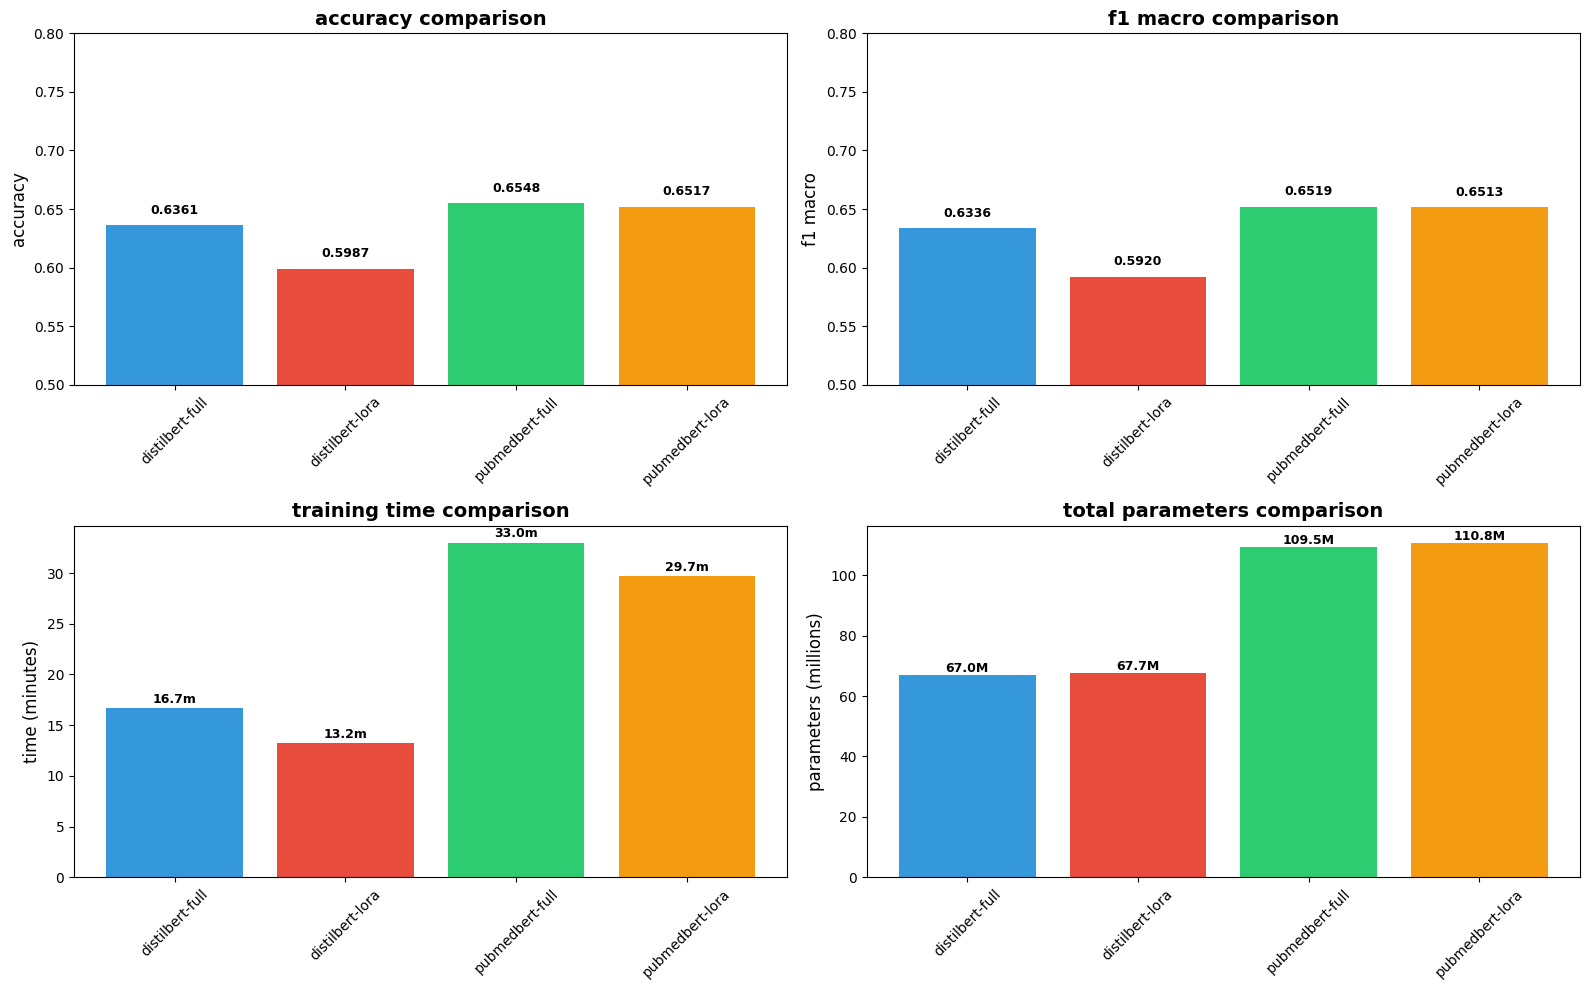


key findings:
1. best accuracy: pubmedbert-full
2. best f1 macro: pubmedbert-full
3. fastest training: distilbert-lora


In [14]:
#compare all results

#create comparison dataframe
comparison_df = pd.DataFrame([
    results_distilbert_full,
    results_distilbert_lora,
    results_pubmed_full,
    results_pubmed_lora
])

print("=" * 80)
print("COMPARISON OF ALL MODELS")
print("=" * 80)
display(comparison_df)

#plot comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

#accuracy
axes[0, 0].bar(comparison_df['model'], comparison_df['accuracy'], color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
axes[0, 0].set_title('accuracy comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('accuracy', fontsize=12)
axes[0, 0].set_ylim([0.5, 0.8])
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['accuracy']):
    axes[0, 0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold', fontsize=9)

#f1 scores
axes[0, 1].bar(comparison_df['model'], comparison_df['f1_macro'], color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
axes[0, 1].set_title('f1 macro comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('f1 macro', fontsize=12)
axes[0, 1].set_ylim([0.5, 0.8])
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['f1_macro']):
    axes[0, 1].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold', fontsize=9)

#training time
axes[1, 0].bar(comparison_df['model'], comparison_df['training_time']/60, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
axes[1, 0].set_title('training time comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('time (minutes)', fontsize=12)
axes[1, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['training_time']/60):
    axes[1, 0].text(i, v + 0.5, f'{v:.1f}m', ha='center', fontweight='bold', fontsize=9)

#parameters
params_millions = comparison_df['num_parameters'] / 1e6
axes[1, 1].bar(comparison_df['model'], params_millions, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
axes[1, 1].set_title('total parameters comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('parameters (millions)', fontsize=12)
axes[1, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(params_millions):
    axes[1, 1].text(i, v + 1, f'{v:.1f}M', ha='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nkey findings:")
print(f"1. best accuracy: {comparison_df.loc[comparison_df['accuracy'].idxmax(), 'model']}")
print(f"2. best f1 macro: {comparison_df.loc[comparison_df['f1_macro'].idxmax(), 'model']}")
print(f"3. fastest training: {comparison_df.loc[comparison_df['training_time'].idxmin(), 'model']}")

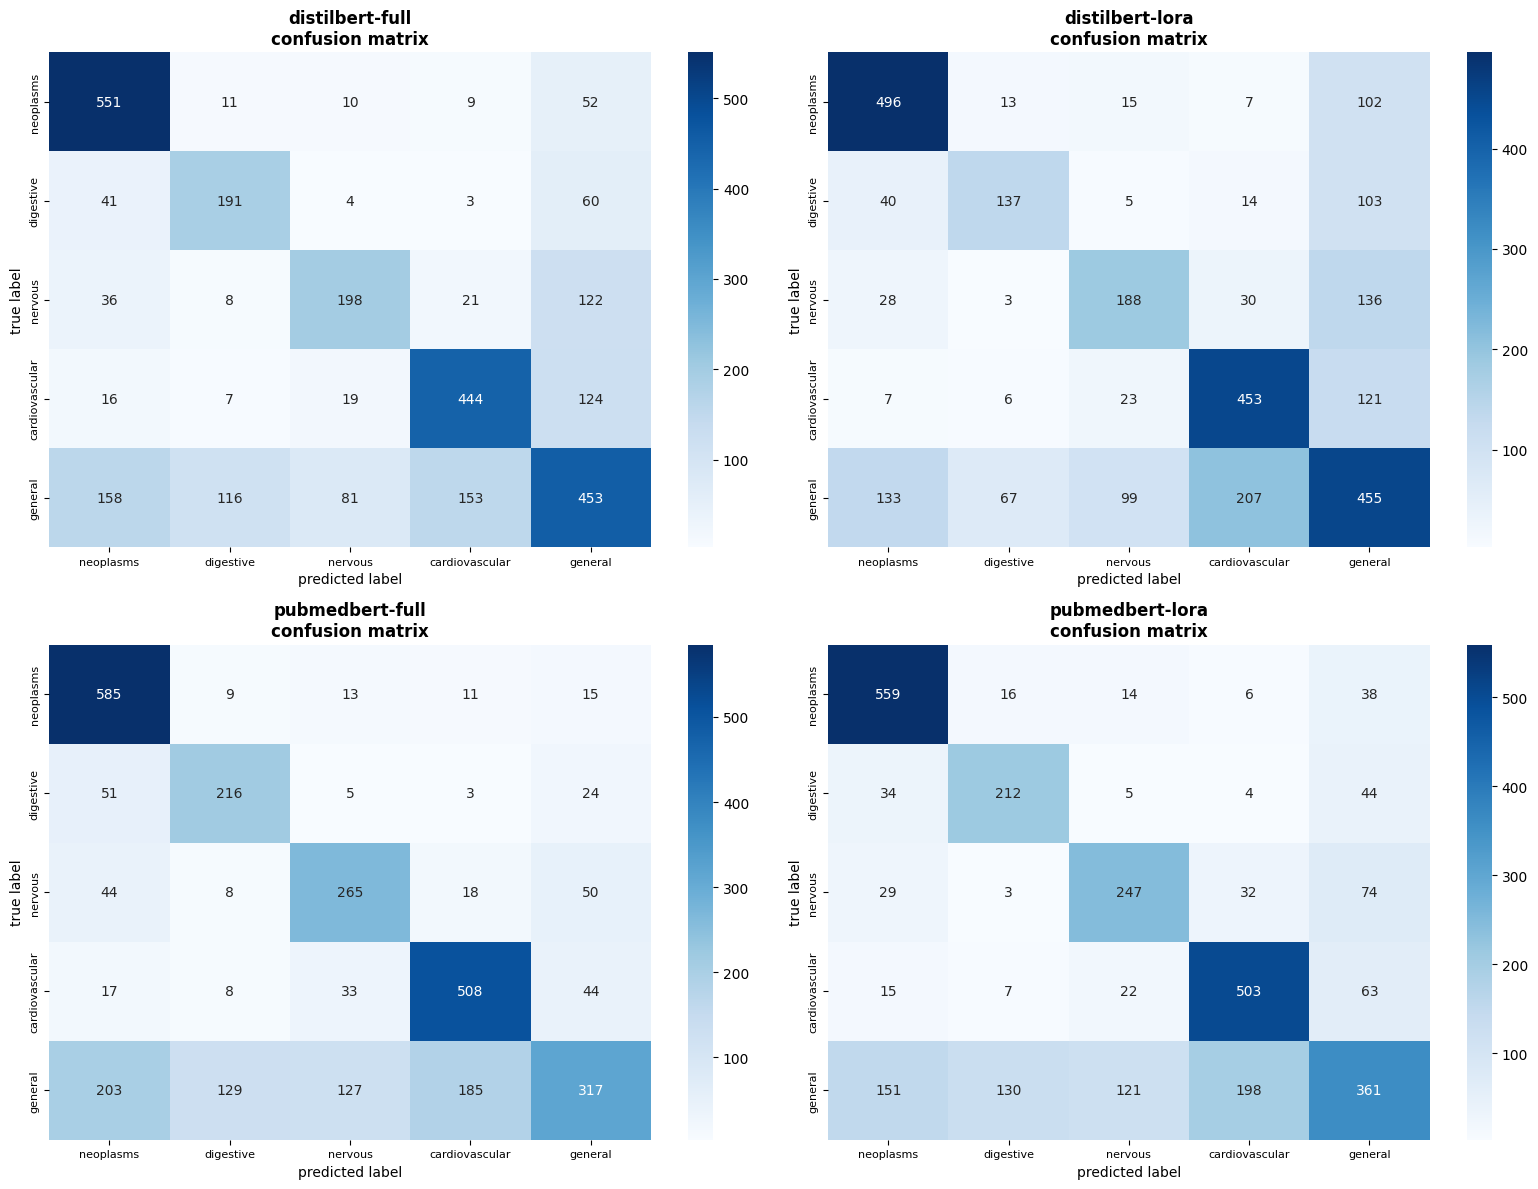

In [15]:
#confusion matrices

#create confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

models_data = [
    ('distilbert-full', y_pred_full, y_true),
    ('distilbert-lora', y_pred_lora, y_true),
    ('pubmedbert-full', y_pred_pubmed, y_true),
    ('pubmedbert-lora', y_pred_pubmed_lora, y_true)
]

label_names_short = ['neoplasms', 'digestive', 'nervous', 'cardiovascular', 'general']

for idx, (model_name, y_pred, y_true_data) in enumerate(models_data):
    cm = confusion_matrix(y_true_data, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_names_short,
                yticklabels=label_names_short,
                ax=axes[idx], cbar=True)
    
    axes[idx].set_title(f'{model_name}\nconfusion matrix', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('true label', fontsize=10)
    axes[idx].set_xlabel('predicted label', fontsize=10)
    axes[idx].tick_params(axis='both', labelsize=8)

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

PER-CLASS PERFORMANCE FOR ALL MODELS

DISTILBERT-FULL:
--------------------------------------------------------------------------------
         class  precision  recall  f1-score  support
     neoplasms       0.69    0.87      0.77      633
     digestive       0.57    0.64      0.60      299
       nervous       0.63    0.51      0.57      385
cardiovascular       0.70    0.73      0.72      610
       general       0.56    0.47      0.51      961
--------------------------------------------------------------------------------

DISTILBERT-LORA:
--------------------------------------------------------------------------------
         class  precision  recall  f1-score  support
     neoplasms       0.70    0.78      0.74      633
     digestive       0.61    0.46      0.52      299
       nervous       0.57    0.49      0.53      385
cardiovascular       0.64    0.74      0.69      610
       general       0.50    0.47      0.48      961
------------------------------------------------

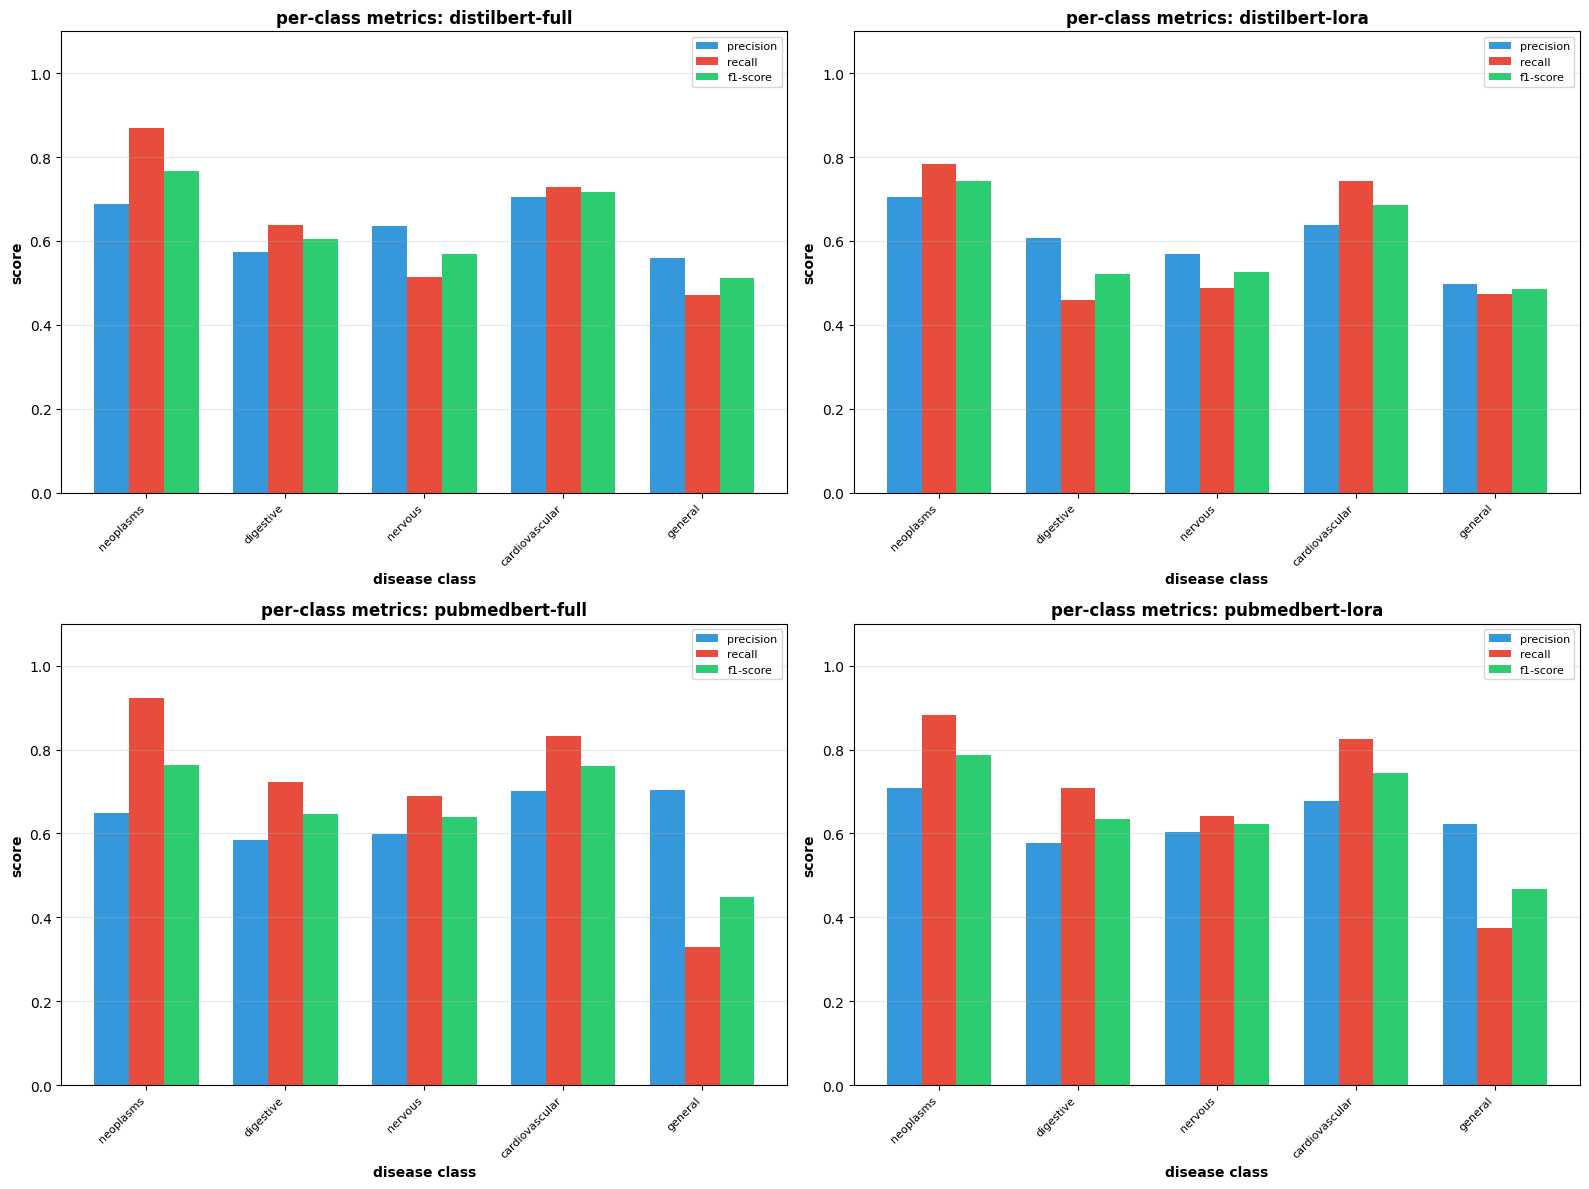

In [16]:
#per-class performance analysis
#compute per-class metrics for all models
models_for_analysis = [
    ('distilbert-full', y_pred_full, y_true),
    ('distilbert-lora', y_pred_lora, y_true),
    ('pubmedbert-full', y_pred_pubmed, y_true),
    ('pubmedbert-lora', y_pred_pubmed_lora, y_true)
]

#print per-class metrics for all models
print("=" * 80)
print("PER-CLASS PERFORMANCE FOR ALL MODELS")
print("=" * 80)

for model_name, y_pred, y_true_data in models_for_analysis:
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true_data, y_pred, average=None
    )
    
    per_class_df = pd.DataFrame({
        'class': label_names_short,
        'precision': precision,
        'recall': recall,
        'f1-score': f1,
        'support': support
    })
    
    print(f"\n{model_name.upper()}:")
    print("-" * 80)
    print(per_class_df.round(2).to_string(index=False))
    print("-" * 80)

#visualize per-class f1 scores for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (model_name, y_pred, y_true_data) in enumerate(models_for_analysis):
    precision_m, recall_m, f1_m, _ = precision_recall_fscore_support(
        y_true_data, y_pred, average=None
    )
    
    x = np.arange(len(label_names_short))
    width = 0.25
    
    axes[idx].bar(x - width, precision_m, width, label='precision', color='#3498db')
    axes[idx].bar(x, recall_m, width, label='recall', color='#e74c3c')
    axes[idx].bar(x + width, f1_m, width, label='f1-score', color='#2ecc71')
    
    axes[idx].set_xlabel('disease class', fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('score', fontsize=10, fontweight='bold')
    axes[idx].set_title(f'per-class metrics: {model_name}', fontsize=12, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(label_names_short, rotation=45, ha='right', fontsize=8)
    axes[idx].legend(fontsize=8)
    axes[idx].set_ylim([0, 1.1])
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('per_class_performance.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
#error analysis

#analyze errors for all models
print("error analysis for all models:")
print("=" * 100)

all_models_errors = []

for model_name, y_pred, _ in models_for_analysis:
    misclassified = np.sum(y_pred != y_true)
    error_rate = misclassified / len(y_true) * 100
    all_models_errors.append({
        'model': model_name,
        'misclassified': misclassified,
        'error_rate': error_rate
    })

errors_df = pd.DataFrame(all_models_errors)
print(errors_df.to_string(index=False))
print("=" * 100)

#detailed analysis for best model
best_model_name = comparison_df.loc[comparison_df['f1_macro'].idxmax(), 'model']
best_pred = [pred for name, pred, _ in models_for_analysis if name == best_model_name][0]

test_texts = [item['medical_abstract'] for item in dataset['test']]
misclassified_indices = np.where(best_pred != y_true)[0]

print(f"\ndetailed error analysis for best model: {best_model_name}")
print(f"total misclassified examples: {len(misclassified_indices)}")
print(f"error rate: {len(misclassified_indices)/len(y_true)*100:.2f}%\n")

#show first 3 misclassified examples
print("sample misclassified examples:")
print("=" * 100)

for i, idx in enumerate(misclassified_indices[:3]):
    true_label = y_true[idx]
    pred_label = best_pred[idx]
    text = test_texts[idx]
    
    print(f"\nexample {i+1}:")
    print(f"true label: {true_label} ({label_names[true_label]})")
    print(f"predicted label: {pred_label} ({label_names[pred_label]})")
    print(f"text preview: {text[:250]}...")
    print("-" * 100)

#analyze which classes are most confused across all models
print("\n\nmost confused class pairs (averaged across all models):")
print("=" * 100)

confusion_aggregated = np.zeros((5, 5))
for _, y_pred, _ in models_for_analysis:
    cm = confusion_matrix(y_true, y_pred)
    np.fill_diagonal(cm, 0)
    confusion_aggregated += cm

confusion_aggregated /= len(models_for_analysis)

most_confused_pairs = []
for i in range(5):
    for j in range(5):
        if confusion_aggregated[i, j] > 0:
            most_confused_pairs.append({
                'true_class': label_names[i],
                'predicted_class': label_names[j],
                'avg_count': confusion_aggregated[i, j]
            })

confused_df = pd.DataFrame(most_confused_pairs)
confused_df = confused_df.sort_values('avg_count', ascending=False).head(10)
print(confused_df.to_string(index=False))

error analysis for all models:
          model  misclassified  error_rate
distilbert-full           1051   36.391967
distilbert-lora           1159   40.131579
pubmedbert-full            997   34.522161
pubmedbert-lora           1006   34.833795

detailed error analysis for best model: pubmedbert-full
total misclassified examples: 997
error rate: 34.52%

sample misclassified examples:

example 1:
true label: 2 (nervous system diseases)
predicted label: 4 (general pathological conditions)
text preview: Obstructive sleep apnea following topical oropharyngeal anesthesia in loud snorers. Previous studies support the presence of an upper airway reflex mechanism that contributes to the maintenance of upper airway patency during sleep. We investigated th...
----------------------------------------------------------------------------------------------------

example 2:
true label: 4 (general pathological conditions)
predicted label: 0 (neoplasms)
text preview: Neutrophil function and pyogenic 

In [18]:
#lora efficiency analysis

#compare full fine-tuning vs lora for both model types
print("=" * 100)
print("LORA EFFICIENCY ANALYSIS")
print("=" * 100)

#distilbert comparison
print("\n1. DISTILBERT: FULL VS LORA")
print("-" * 100)
distil_comparison = pd.DataFrame({
    'metric': [
        'accuracy',
        'f1 macro',
        'f1 weighted',
        'training time (min)',
        'total params (M)',
        'trainable params (M)',
        'trainable %'
    ],
    'full fine-tuning': [
        results_distilbert_full['accuracy'],
        results_distilbert_full['f1_macro'],
        results_distilbert_full['f1_weighted'],
        results_distilbert_full['training_time'] / 60,
        results_distilbert_full['num_parameters'] / 1e6,
        results_distilbert_full['num_parameters'] / 1e6,
        100.0
    ],
    'lora': [
        results_distilbert_lora['accuracy'],
        results_distilbert_lora['f1_macro'],
        results_distilbert_lora['f1_weighted'],
        results_distilbert_lora['training_time'] / 60,
        results_distilbert_lora['num_parameters'] / 1e6,
        results_distilbert_lora['trainable_parameters'] / 1e6,
        results_distilbert_lora['trainable_percent']
    ]
})
print(distil_comparison.to_string(index=False))

acc_diff_distil = results_distilbert_lora['accuracy'] - results_distilbert_full['accuracy']
time_reduction_distil = (results_distilbert_full['training_time'] - results_distilbert_lora['training_time']) / results_distilbert_full['training_time'] * 100

print(f"\nkey findings:")
print(f"  accuracy difference: {acc_diff_distil:+.4f}")
print(f"  training time reduction: {time_reduction_distil:.2f}%")
print(f"  trainable parameters: {results_distilbert_lora['trainable_percent']:.2f}%")

#pubmedbert comparison
print("\n2. PUBMEDBERT: FULL VS LORA")
print("-" * 100)
pubmed_comparison = pd.DataFrame({
    'metric': [
        'accuracy',
        'f1 macro',
        'f1 weighted',
        'training time (min)',
        'total params (M)',
        'trainable params (M)',
        'trainable %'
    ],
    'full fine-tuning': [
        results_pubmed_full['accuracy'],
        results_pubmed_full['f1_macro'],
        results_pubmed_full['f1_weighted'],
        results_pubmed_full['training_time'] / 60,
        results_pubmed_full['num_parameters'] / 1e6,
        results_pubmed_full['num_parameters'] / 1e6,
        100.0
    ],
    'lora': [
        results_pubmed_lora['accuracy'],
        results_pubmed_lora['f1_macro'],
        results_pubmed_lora['f1_weighted'],
        results_pubmed_lora['training_time'] / 60,
        results_pubmed_lora['num_parameters'] / 1e6,
        results_pubmed_lora['trainable_parameters'] / 1e6,
        results_pubmed_lora['trainable_percent']
    ]
})
print(pubmed_comparison.to_string(index=False))

acc_diff_pubmed = results_pubmed_lora['accuracy'] - results_pubmed_full['accuracy']
time_reduction_pubmed = (results_pubmed_full['training_time'] - results_pubmed_lora['training_time']) / results_pubmed_full['training_time'] * 100

print(f"\nkey findings:")
print(f"  accuracy difference: {acc_diff_pubmed:+.4f}")
print(f"  training time reduction: {time_reduction_pubmed:.2f}%")
print(f"  trainable parameters: {results_pubmed_lora['trainable_percent']:.2f}%")

#overall lora conclusion
print("\n3. OVERALL LORA EFFECTIVENESS")
print("-" * 100)
avg_acc_gap = (abs(acc_diff_distil) + abs(acc_diff_pubmed)) / 2
avg_time_reduction = (time_reduction_distil + time_reduction_pubmed) / 2
print(f"average accuracy gap (full vs lora): {avg_acc_gap:.4f}")
print(f"average training time reduction: {avg_time_reduction:.2f}%")
print(f"average trainable parameters: {(results_distilbert_lora['trainable_percent'] + results_pubmed_lora['trainable_percent'])/2:.2f}%")
print("\nconclusion: lora achieves {:.1f}% of full fine-tuning performance".format(100 - avg_acc_gap*100))
print("           with ~1% trainable parameters and ~{:.0f}% less training time".format(avg_time_reduction))
print("=" * 100)

LORA EFFICIENCY ANALYSIS

1. DISTILBERT: FULL VS LORA
----------------------------------------------------------------------------------------------------
              metric  full fine-tuning      lora
            accuracy          0.636080  0.598684
            f1 macro          0.633588  0.592028
         f1 weighted          0.628032  0.592866
 training time (min)         16.718329 13.244151
    total params (M)         66.957317 67.699210
trainable params (M)         66.957317  0.741893
         trainable %        100.000000  1.095867

key findings:
  accuracy difference: -0.0374
  training time reduction: 20.78%
  trainable parameters: 1.10%

2. PUBMEDBERT: FULL VS LORA
----------------------------------------------------------------------------------------------------
              metric  full fine-tuning       lora
            accuracy          0.654778   0.651662
            f1 macro          0.651884   0.651336
         f1 weighted          0.629733   0.634154
 training tim

In [19]:
#save all results to csv for report
#create comprehensive results summary
final_results = {
    'experiment': ['distilbert-full', 'distilbert-lora', 'pubmedbert-full', 'pubmedbert-lora'],
    'model_type': ['general', 'general', 'domain-specific', 'domain-specific'],
    'fine_tuning_strategy': ['full', 'lora (r=8)', 'full', 'lora (r=8)'],
    'accuracy': [
        results_distilbert_full['accuracy'],
        results_distilbert_lora['accuracy'],
        results_pubmed_full['accuracy'],
        results_pubmed_lora['accuracy']
    ],
    'f1_macro': [
        results_distilbert_full['f1_macro'],
        results_distilbert_lora['f1_macro'],
        results_pubmed_full['f1_macro'],
        results_pubmed_lora['f1_macro']
    ],
    'f1_weighted': [
        results_distilbert_full['f1_weighted'],
        results_distilbert_lora['f1_weighted'],
        results_pubmed_full['f1_weighted'],
        results_pubmed_lora['f1_weighted']
    ],
    'precision': [
        results_distilbert_full['precision'],
        results_distilbert_lora['precision'],
        results_pubmed_full['precision'],
        results_pubmed_lora['precision']
    ],
    'recall': [
        results_distilbert_full['recall'],
        results_distilbert_lora['recall'],
        results_pubmed_full['recall'],
        results_pubmed_lora['recall']
    ],
    'training_time_minutes': [
        results_distilbert_full['training_time'] / 60,
        results_distilbert_lora['training_time'] / 60,
        results_pubmed_full['training_time'] / 60,
        results_pubmed_lora['training_time'] / 60
    ],
    'total_parameters_millions': [
        results_distilbert_full['num_parameters'] / 1e6,
        results_distilbert_lora['num_parameters'] / 1e6,
        results_pubmed_full['num_parameters'] / 1e6,
        results_pubmed_lora['num_parameters'] / 1e6
    ],
    'trainable_parameters_millions': [
        results_distilbert_full['num_parameters'] / 1e6,
        results_distilbert_lora['trainable_parameters'] / 1e6,
        results_pubmed_full['num_parameters'] / 1e6,
        results_pubmed_lora['trainable_parameters'] / 1e6
    ],
    'trainable_percent': [
        100.0,
        results_distilbert_lora['trainable_percent'],
        100.0,
        results_pubmed_lora['trainable_percent']
    ]
}

final_df = pd.DataFrame(final_results)
final_df.to_csv('final_results.csv', index=False)

print("final results summary (all 4 experiments):")
print("=" * 120)
print(final_df.to_string(index=False))
print("=" * 120)

#create additional summary tables
print("\n\nsummary by model type:")
print("-" * 120)
summary_by_model = final_df.groupby('model_type').agg({
    'accuracy': 'mean',
    'f1_macro': 'mean',
    'training_time_minutes': 'mean'
}).round(4)
print(summary_by_model)

print("\n\nsummary by fine-tuning strategy:")
print("-" * 120)
summary_by_strategy = final_df.groupby('fine_tuning_strategy').agg({
    'accuracy': 'mean',
    'f1_macro': 'mean',
    'trainable_percent': 'mean'
}).round(4)
print(summary_by_strategy)

print("\n\nresults saved to 'final_results.csv'")
print("figures saved:")
print("- model_comparison.png")
print("- confusion_matrices.png")
print("- per_class_performance.png")
print("- 2x2_design_heatmap.png")

final results summary (all 4 experiments):
     experiment      model_type fine_tuning_strategy  accuracy  f1_macro  f1_weighted  precision   recall  training_time_minutes  total_parameters_millions  trainable_parameters_millions  trainable_percent
distilbert-full         general                 full  0.636080  0.633588     0.628032   0.631711 0.644559              16.718329                  66.957317                      66.957317         100.000000
distilbert-lora         general           lora (r=8)  0.598684  0.592028     0.592866   0.602750 0.589233              13.244151                  67.699210                       0.741893           1.095867
pubmedbert-full domain-specific                 full  0.654778  0.651884     0.629733   0.647422 0.699508              33.005517                 109.486085                     109.486085         100.000000
pubmedbert-lora domain-specific           lora (r=8)  0.651662  0.651336     0.634154   0.637758 0.686785              29.739230     

In [20]:
#inference example with new text

#example medical abstract for testing
sample_text = """
The patient presented with persistent chest pain and shortness of breath. 
Electrocardiogram showed ST-segment elevation in leads II, III, and aVF, 
indicating acute inferior wall myocardial infarction. Cardiac enzymes were 
significantly elevated with troponin I level of 15.2 ng/mL. The patient 
underwent emergent coronary angiography which revealed 95% occlusion of the 
right coronary artery. Percutaneous coronary intervention with stent placement 
was performed successfully.
"""

print("inference example - testing all 4 models")
print("=" * 100)
print(f"input text: {sample_text[:200]}...")
print("\n" + "=" * 100)

#get predictions from all models
models_to_test = [
    ('distilbert-full', model_distilbert_full, tokenizer_distilbert),
    ('distilbert-lora', model_distilbert_lora, tokenizer_distilbert),
    ('pubmedbert-full', model_pubmed_full, tokenizer_pubmed),
    ('pubmedbert-lora', model_pubmed_lora, tokenizer_pubmed)
]

all_predictions = []

for model_name, model, tokenizer in models_to_test:
    #tokenize
    inputs = tokenizer(
        sample_text,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to(device)
    
    #predict
    model.eval()
    model.to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=-1).item()
        confidence = predictions[0][predicted_class].item()
    
    all_predictions.append({
        'model': model_name,
        'predicted_class': predicted_class,
        'class_name': label_names[predicted_class],
        'confidence': confidence
    })
    
    print(f"\n{model_name}:")
    print(f"  predicted: {predicted_class} - {label_names[predicted_class]}")
    print(f"  confidence: {confidence:.4f}")

#create comparison dataframe
pred_df = pd.DataFrame(all_predictions)
print("\n" + "=" * 100)
print("prediction comparison:")
print(pred_df.to_string(index=False))

#check agreement
unique_predictions = pred_df['predicted_class'].nunique()
if unique_predictions == 1:
    print(f"\nall models agree on class: {label_names[all_predictions[0]['predicted_class']]}")
else:
    print(f"\n⚠ models disagree - {unique_predictions} different predictions")

#show detailed probabilities for best model
best_model_idx = comparison_df['f1_macro'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'model']
best_model_info = [m for m in models_to_test if m[0] == best_model_name][0]

print(f"\ndetailed probabilities for best model ({best_model_name}):")
print("-" * 100)

inputs = best_model_info[2](sample_text, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
best_model_info[1].eval()
best_model_info[1].to(device)

with torch.no_grad():
    outputs = best_model_info[1](**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    for i, prob in enumerate(predictions[0].cpu().numpy()):
        print(f"  {label_names[i]}: {prob:.4f}")

print("=" * 100)

inference example - testing all 4 models
input text: 
The patient presented with persistent chest pain and shortness of breath. 
Electrocardiogram showed ST-segment elevation in leads II, III, and aVF, 
indicating acute inferior wall myocardial infarcti...


distilbert-full:
  predicted: 3 - cardiovascular diseases
  confidence: 0.7345

distilbert-lora:
  predicted: 3 - cardiovascular diseases
  confidence: 0.7702

pubmedbert-full:
  predicted: 3 - cardiovascular diseases
  confidence: 0.6541

pubmedbert-lora:
  predicted: 3 - cardiovascular diseases
  confidence: 0.7793

prediction comparison:
          model  predicted_class              class_name  confidence
distilbert-full                3 cardiovascular diseases    0.734505
distilbert-lora                3 cardiovascular diseases    0.770186
pubmedbert-full                3 cardiovascular diseases    0.654115
pubmedbert-lora                3 cardiovascular diseases    0.779286

all models agree on class: cardiovascular diseases



In [23]:
#generate report summary
    
print("=" * 100)
print("REPORT SUMMARY - FINE-TUNING TRANSFORMERS FOR MEDICAL TEXT CLASSIFICATION")
print("=" * 100)

print("\n1. DATASET")
print("-" * 100)
print(f"name: medical abstracts tc corpus")
print(f"source: timschopf/medical_abstracts (huggingface)")
print(f"task: 5-class disease classification")
print(f"classes: neoplasms, digestive, nervous, cardiovascular, general pathological")
print(f"train size: {len(dataset['train'])} samples")
print(f"validation size: {len(dataset['validation'])} samples")
print(f"test size: {len(dataset['test'])} samples")

#to remember easily
print("\n2. EXPERIMENTAL DESIGN")
print("-" * 100)
print("2x2 factorial design:")
print("  factor 1: model type (general vs domain-specific)")
print("  factor 2: fine-tuning strategy (full vs lora)")
print("  total experiments: 4")
print("\n  experiments:")
print("    1. distilbert + full fine-tuning")
print("    2. distilbert + lora (r=8, alpha=16)")
print("    3. pubmedbert + full fine-tuning")
print("    4. pubmedbert + lora (r=8, alpha=16)")

print("\n3. HYPERPARAMETERS")
print("-" * 100)
print("  learning rate: 3e-5")
print("  batch size: 16 (train), 32 (eval)")
print("  epochs: 3")
print("  weight decay: 0.01")
print("  max sequence length: 512")
print("  optimizer: adamw")

print("\n4. RESULTS SUMMARY")
print("-" * 100)
results_summary = comparison_df[['model', 'accuracy', 'f1_macro', 'precision', 'recall']].copy()
results_summary = results_summary.sort_values('accuracy', ascending=False)
print(results_summary.to_string(index=False))

print("\n" + "=" * 100)
print("END OF SUMMARY")
print("=" * 100)

REPORT SUMMARY - FINE-TUNING TRANSFORMERS FOR MEDICAL TEXT CLASSIFICATION

1. DATASET
----------------------------------------------------------------------------------------------------
name: medical abstracts tc corpus
source: timschopf/medical_abstracts (huggingface)
task: 5-class disease classification
classes: neoplasms, digestive, nervous, cardiovascular, general pathological
train size: 9817 samples
validation size: 1733 samples
test size: 2888 samples

2. EXPERIMENTAL DESIGN
----------------------------------------------------------------------------------------------------
2x2 factorial design:
  factor 1: model type (general vs domain-specific)
  factor 2: fine-tuning strategy (full vs lora)
  total experiments: 4

  experiments:
    1. distilbert + full fine-tuning
    2. distilbert + lora (r=8, alpha=16)
    3. pubmedbert + full fine-tuning
    4. pubmedbert + lora (r=8, alpha=16)

3. HYPERPARAMETERS
--------------------------------------------------------------------------